## **Maestría en Ciencia de Datos - FDA II**
### **Daniel Martínez & Felipe Montenegro**




# **Problema a Desarrollar**

**Contexto del Negocio**

El cáncer de próstata es uno de los tipos de cáncer más comunes en hombres. La detección temprana es crucial para mejorar las tasas de supervivencia. La prueba de antígeno prostático específico (PSA) puede ayudar a detectar el cáncer de próstata en etapas tempranas, cuando es más tratable. Sin embargo, el PSA no es específico para el cáncer de próstata y puede estar elevado en otras condiciones como prostatitis o hiperplasia prostática benigna (HPB).

El antígeno prostático específico (PSA) es una proteína producida por células normales y malignas de la glándula prostática. La prueba del PSA mide el nivel de esta proteína en la sangre y es uno de los métodos más utilizados para el tamizaje del cáncer de próstata.

La EPS SaludPorTi, está interesado en priorizar la toma de está prueba, aumentando la demanda y detención temprana del Cáncer de Próstata.


**Problema de Negocio** 

La empresa ha decidido contratarlos para que construyan un modelo predictivo que permita estimar la probabilidad de que un usuario entre 48 y 60 años de edad presente resultados anormales de PSA.


**Contexto Analítico** 

Se espera que entrene diferentes familias de modelos predictivos de clasificación (SVC con diferentes kernels, Redes Neuronales poco profundas), precedidos por diferentes procesos de transformación (normalizaciones, imputación, feature engineering, dummificación, PCA, selección de features).

La evaluación de la calidad de los flujos de modelos predictivos se debe estimar utilizando la métrica de ROC_AUC.

Expliquen sus ideas, el por qué realizan las acciones, y comenten los resultados obtenidos; se espera mucho más que unos bloques de código.
La toma de decisiones sobre los datos se debe hacer considerando el contexto del problema y de los datos, no se puede ver todo solamente desde los ojos de los datos, sino también considerar el negocio.
Un Científico de Datos debe poder comunicar los puntos importantes de su trabajo en un lenguaje universal para todos los públicos.



## **1. Carga de Librerías y Lectura de Datos**

In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from IPython.display import display 

import warnings
warnings.filterwarnings("ignore") 

In [2]:
df_train = pq.read_table('data/df_train.parquet').to_pandas()
df_test = pq.read_table('data/df_test.parquet').to_pandas()

## **2. Análisis Exploratorio de Datos**

In [3]:
#Visualización inicial de los datos

df_train.head()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


In [4]:
#Identificamos el tipo de datos que contiene el dataset 

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   23494 non-null  float64
 1   MEDICINA ESPECIALIZADA         23494 non-null  float64
 2   MEDICINA GENERAL               23494 non-null  float64
 3   Cant_gr_flia                   23494 non-null  int64  
 4   Cant_riesgos_flia_mean         23494 non-null  float64
 5   min_Tiempo_CP_Fliar            8 non-null      float64
 6   Cant_Fliar_CP                  23494 non-null  float64
 7   psa_max_gr_flia                164 non-null    float64
 8   psa_min_gr_flia                164 non-null    float64
 9   Cant_Fliar_riesgos             23494 non-null  float64
 10  cantidad_serv_flia             23494 non-null  float64
 11  Pendiente_flia                 23494 non-null  float64
 12  Intercepto_flia                23494 non-null  f

In [4]:
#Identificamos el grupo de variables numéricas y categóricas, que serán utilizadas para realizar un análisis descriptivo inicial. 

df_numerico = df_train.select_dtypes(include=['int64', 'float64'])

df_categorico = df_train.select_dtypes(include=['object', 'category'])




## **2.1. Análisis Exploratorio de Variables Numéricas**

In [6]:
df_numerico.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MEDICAMENTOS            23494 non-null  float64
 1   MEDICINA ESPECIALIZADA  23494 non-null  float64
 2   MEDICINA GENERAL        23494 non-null  float64
 3   Cant_gr_flia            23494 non-null  int64  
 4   Cant_riesgos_flia_mean  23494 non-null  float64
 5   min_Tiempo_CP_Fliar     8 non-null      float64
 6   Cant_Fliar_CP           23494 non-null  float64
 7   psa_max_gr_flia         164 non-null    float64
 8   psa_min_gr_flia         164 non-null    float64
 9   Cant_Fliar_riesgos      23494 non-null  float64
 10  cantidad_serv_flia      23494 non-null  float64
 11  Pendiente_flia          23494 non-null  float64
 12  Intercepto_flia         23494 non-null  float64
 13  Promedio_costo_flia     23494 non-null  float64
 14  EDAD                    23494 non-null  

In [11]:
# Función para obtener la tabla completa de estadísticas descriptivas
def tabla_descriptivas_completa(columnas):
    tabla_descriptivas = pd.DataFrame(columnas.describe())
    tabla_descriptivas.loc['coef. variation'] = columnas.std() / columnas.mean()
    tabla_descriptivas.loc['skew'] = skew(columnas) 
    tabla_descriptivas.loc['kurtosis'] = kurtosis(columnas)
    return tabla_descriptivas

**Estadísticas Descriptivas**

In [14]:
columnas_numericas = df_numerico.select_dtypes(include=['float64', 'int64']).columns


resultados = {}


for columna in columnas_numericas:
    resultados[columna] = tabla_descriptivas_completa(df_numerico[columna])


for key, value in resultados.items():
    print(f"\nEstadísticas descriptivas para {key}:\n")
    display(value)  # Mostrar la tabla con formato
    print("\n" + "="*50 + "\n")


Estadísticas descriptivas para MEDICAMENTOS:



,MEDICAMENTOS
count,23494.000000
mean,5.201669
std,8.830948
min,0.000000
25%,0.000000
50%,2.000000
75%,6.000000
max,91.000000
coef. variation,1.697714
skew,3.030693





Estadísticas descriptivas para MEDICINA ESPECIALIZADA:



,MEDICINA ESPECIALIZADA
count,23494.000000
mean,1.285094
std,2.669005
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,44.000000
coef. variation,2.076895
skew,5.041089





Estadísticas descriptivas para MEDICINA GENERAL:



,MEDICINA GENERAL
count,23494.000000
mean,1.244190
std,1.337775
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,23.000000
coef. variation,1.075218
skew,2.598851





Estadísticas descriptivas para Cant_gr_flia:



,Cant_gr_flia
count,23494.000000
mean,2.451392
std,1.153336
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,10.000000
coef. variation,0.470482
skew,0.732894





Estadísticas descriptivas para Cant_riesgos_flia_mean:



,Cant_riesgos_flia_mean
count,23494.000000
mean,0.227974
std,0.485658
min,0.000000
25%,0.000000
50%,0.000000
75%,0.333333
max,6.000000
coef. variation,2.130325
skew,3.464443





Estadísticas descriptivas para min_Tiempo_CP_Fliar:



,min_Tiempo_CP_Fliar
count,8.000000
mean,95.000000
std,86.194133
min,23.000000
25%,41.000000
50%,73.000000
75%,102.250000
max,284.000000
coef. variation,0.907307
skew,NaN





Estadísticas descriptivas para Cant_Fliar_CP:



,Cant_Fliar_CP
count,23494.000000
mean,0.000341
std,0.018450
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000
coef. variation,54.183715
skew,54.164106





Estadísticas descriptivas para psa_max_gr_flia:



,psa_max_gr_flia
count,164.000000
mean,8.538970
std,44.400913
min,0.005000
25%,0.978750
50%,2.420000
75%,4.995000
max,550.000000
coef. variation,5.199798
skew,NaN





Estadísticas descriptivas para psa_min_gr_flia:



,psa_min_gr_flia
count,164.000000
mean,2.986841
std,4.734082
min,0.000000
25%,0.845750
50%,1.785000
75%,3.552500
max,49.000000
coef. variation,1.584979
skew,NaN





Estadísticas descriptivas para Cant_Fliar_riesgos:



,Cant_Fliar_riesgos
count,23494.000000
mean,0.291947
std,0.454761
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000
coef. variation,1.557685
skew,0.916565





Estadísticas descriptivas para cantidad_serv_flia:



,cantidad_serv_flia
count,23494.000000
mean,26.627650
std,32.429647
min,1.000000
25%,7.000000
50%,17.000000
75%,36.000000
max,1090.000000
coef. variation,1.217894
skew,7.422421





Estadísticas descriptivas para Pendiente_flia:



,Pendiente_flia
count,2.349400e+04
mean,1.346736e+04
std,5.303226e+05
min,-2.028200e+07
25%,-4.156893e+03
50%,0.000000e+00
75%,1.230953e+04
max,2.101841e+07
coef. variation,3.937838e+01
skew,-8.671011e-02





Estadísticas descriptivas para Intercepto_flia:



,Intercepto_flia
count,2.349400e+04
mean,2.605611e+05
std,2.470297e+06
min,-4.811983e+07
25%,-2.069767e+03
50%,8.082000e+02
75%,1.029201e+05
max,1.186347e+08
coef. variation,9.480681e+00
skew,2.132309e+01





Estadísticas descriptivas para Promedio_costo_flia:



,Promedio_costo_flia
count,2.349400e+04
mean,4.492140e+05
std,1.972836e+06
min,0.000000e+00
25%,6.291750e+03
50%,7.788450e+04
75%,2.429423e+05
max,1.072898e+08
coef. variation,4.391752e+00
skew,2.052473e+01





Estadísticas descriptivas para EDAD:



,EDAD
count,23494.000000
mean,54.372648
std,3.438426
min,49.000000
25%,51.000000
50%,54.000000
75%,57.000000
max,60.000000
coef. variation,0.063238
skew,0.085510





Estadísticas descriptivas para RIESGOS:



,RIESGOS
count,7211.000000
mean,1.492997
std,0.792335
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,8.000000
coef. variation,0.530701
skew,NaN





Estadísticas descriptivas para CANTIDAD_SERVICIOS:



,CANTIDAD_SERVICIOS
count,23494.000000
mean,8.861156
std,12.090472
min,1.000000
25%,2.000000
50%,5.000000
75%,11.000000
max,262.000000
coef. variation,1.364435
skew,4.875718





Estadísticas descriptivas para PERDIDA_DE_PESO:



,PERDIDA_DE_PESO
count,5771.000000
mean,0.170005
std,8.040427
min,-62.500000
25%,-2.560000
50%,0.000000
75%,2.270000
max,157.140000
coef. variation,47.295183
skew,NaN





Estadísticas descriptivas para TIEMPO_ULTIMA_CITA:



,TIEMPO_ULTIMA_CITA
count,23494.000000
mean,2.219928
std,3.991257
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,36.000000
coef. variation,1.797921
skew,7.413248





Estadísticas descriptivas para conteo_dx_diferentes:



,conteo_dx_diferentes
count,23494.000000
mean,2.918532
std,2.193799
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,25.000000
coef. variation,0.751679
skew,2.181110





Estadísticas descriptivas para TIEMPO_AFILIACION:



,TIEMPO_AFILIACION
count,23494.000000
mean,135.953520
std,104.881494
min,7.000000
25%,38.000000
50%,103.000000
75%,244.000000
max,350.000000
coef. variation,0.771451
skew,0.353723





Estadísticas descriptivas para Pendiente:



,Pendiente
count,2.349400e+04
mean,1.485093e+04
std,4.270672e+05
min,-2.030057e+07
25%,-4.412050e+03
50%,3.118857e+03
75%,1.459710e+04
max,1.490708e+07
coef. variation,2.875693e+01
skew,-1.772639e+00





Estadísticas descriptivas para Intercepto:



,Intercepto
count,2.349400e+04
mean,1.495688e+05
std,1.854731e+06
min,-3.337852e+07
25%,-1.678853e+04
50%,4.090667e+03
75%,7.573733e+04
max,1.013168e+08
coef. variation,1.240052e+01
skew,2.431159e+01





Estadísticas descriptivas para Promedio_costo:



,Promedio_costo
count,2.349400e+04
mean,3.107291e+05
std,1.424497e+06
min,1.000000e+00
25%,3.267192e+04
50%,7.961250e+04
75%,1.793700e+05
max,9.516344e+07
coef. variation,4.584370e+00
skew,2.440668e+01


**Interpretación:**

PENDIENTE

**Gráficos de Distribución de Variables Numéricas**

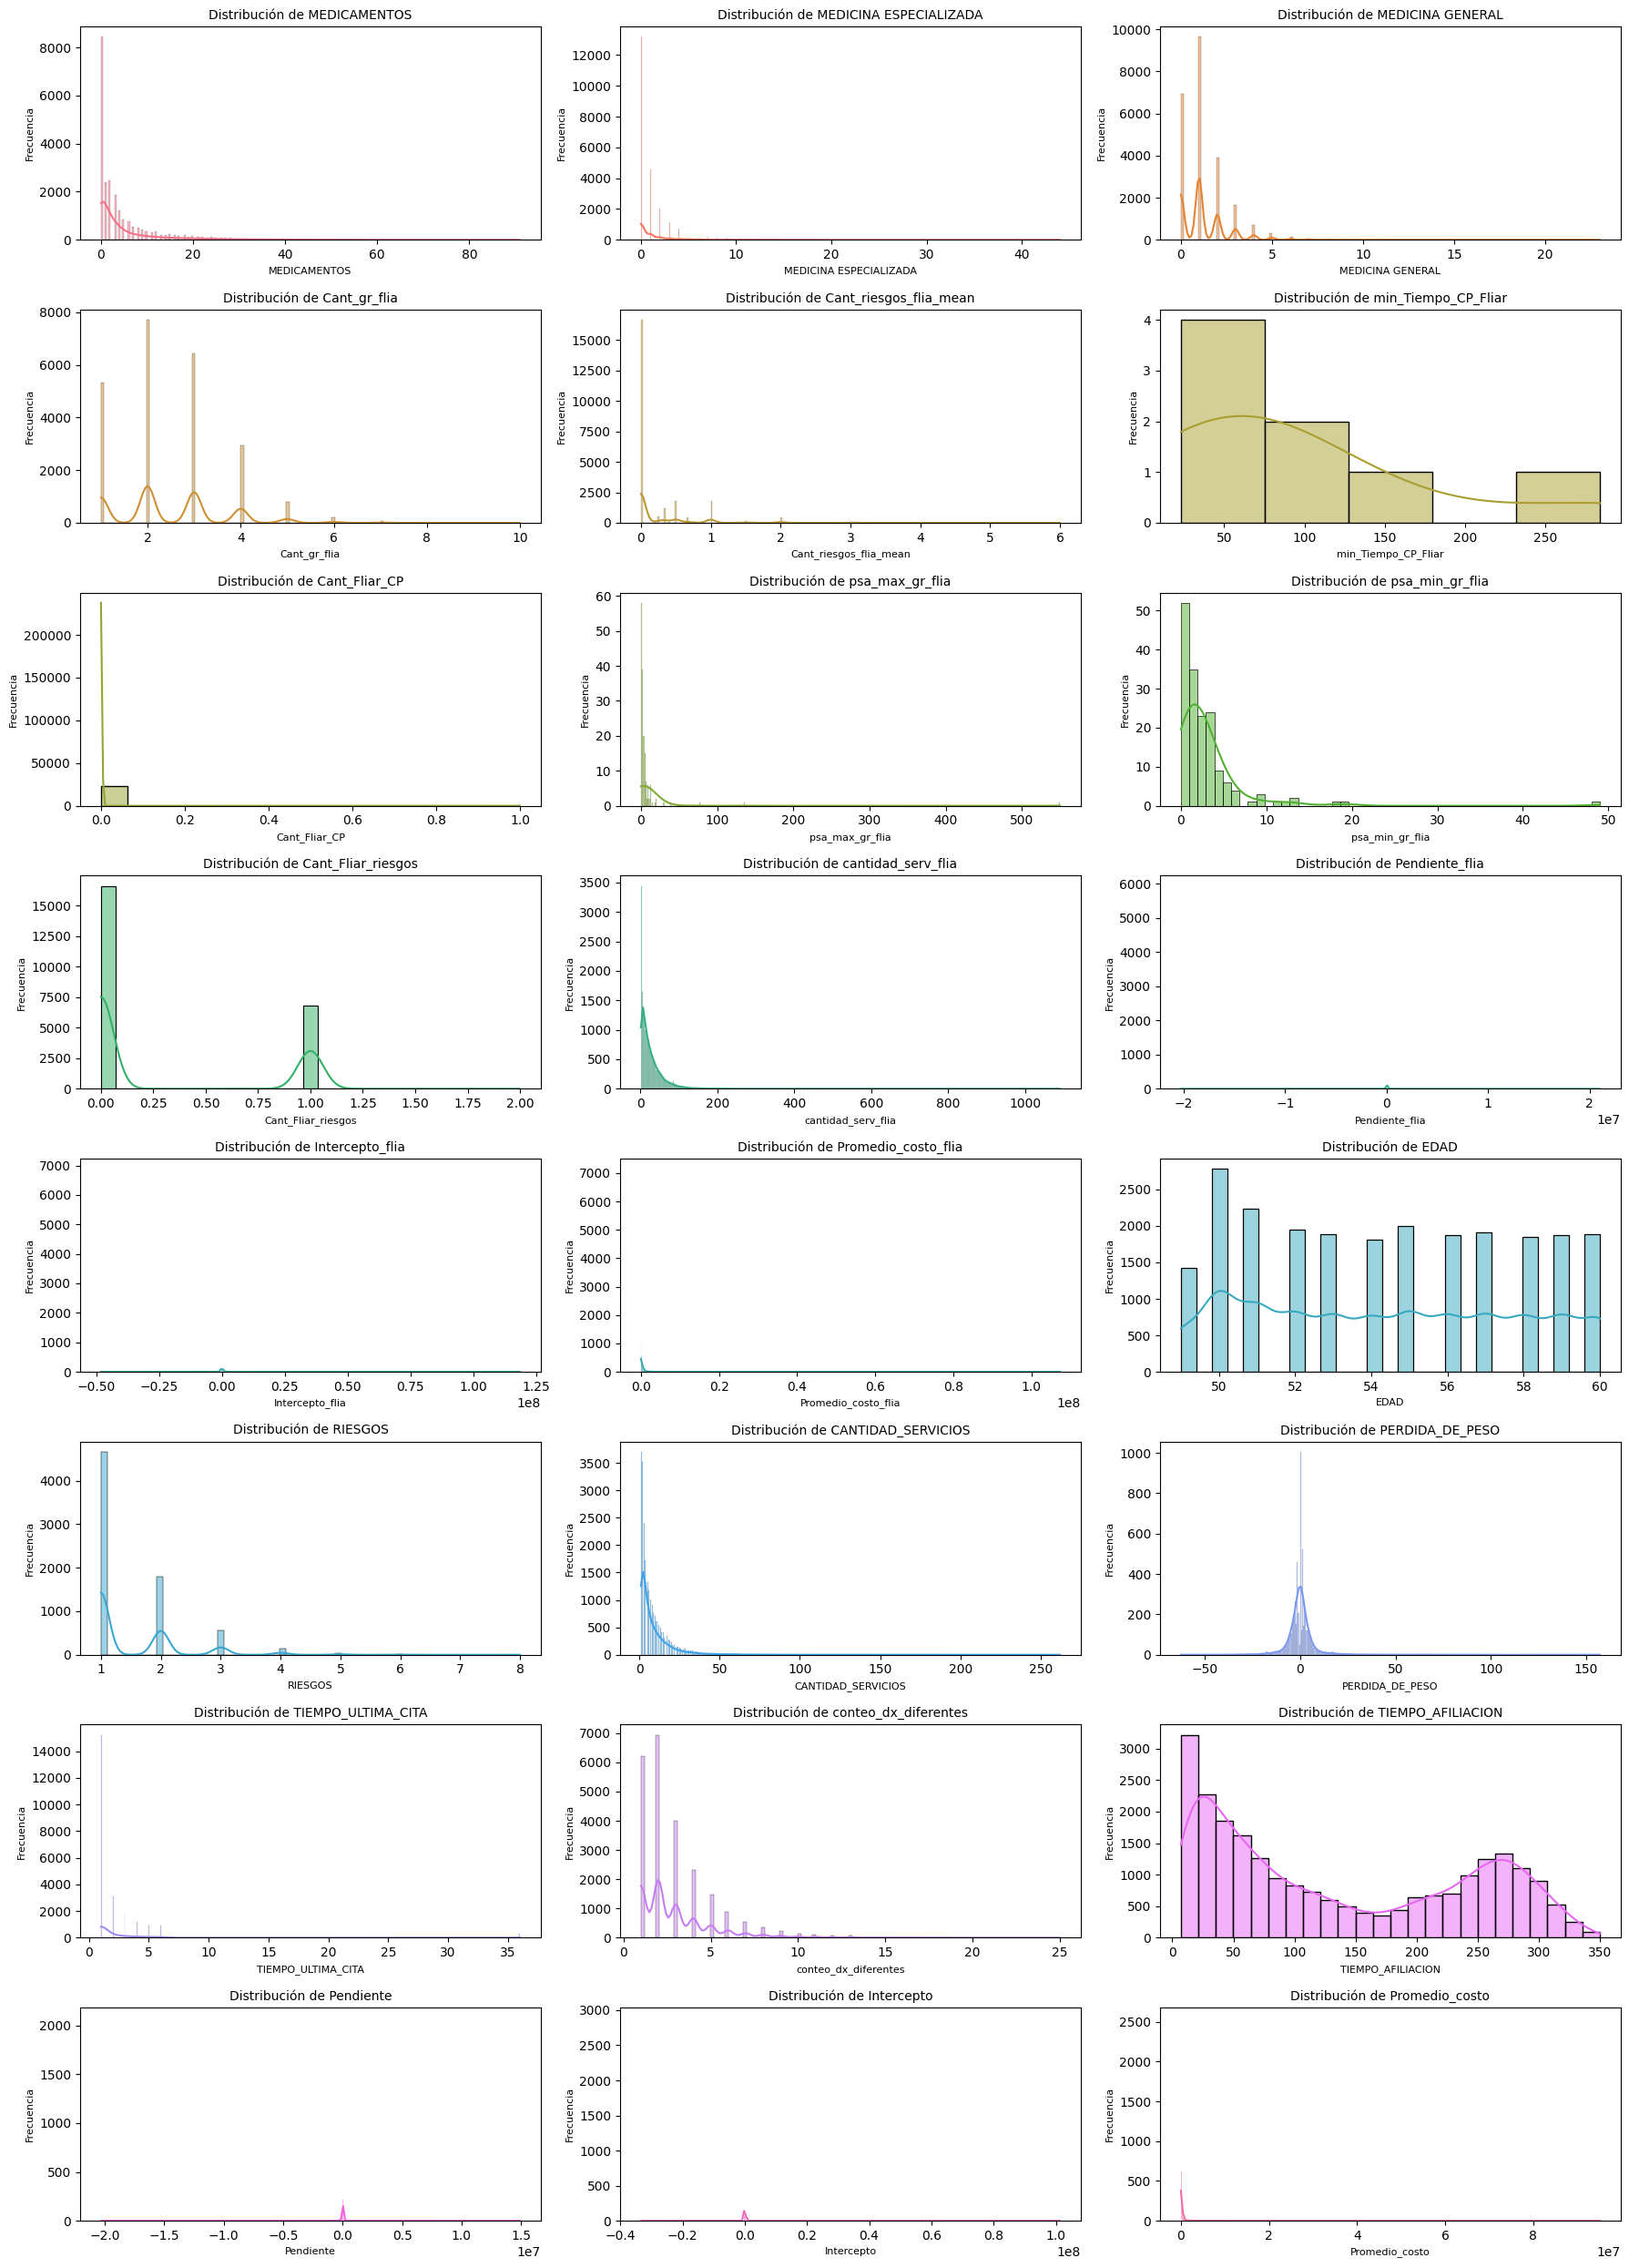

In [17]:
columnas_numericas = df_numerico.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(18, 25))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

colores = sns.color_palette("husl", len(columnas_numericas))

for i, (columna, ax) in enumerate(zip(columnas_numericas, axes.flatten())):
    sns.histplot(x=df_numerico[columna], kde=True, color=colores[i], ax=ax)
    ax.set_title(f'Distribución de {columna}', fontsize=10)
    ax.set_xlabel(f'{columna}', fontsize=8)
    ax.set_ylabel('Frecuencia', fontsize=8)

for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


**Interpretación** 

PENDIENTE

**Gráficas de Boxplot - Variables Numéricas**

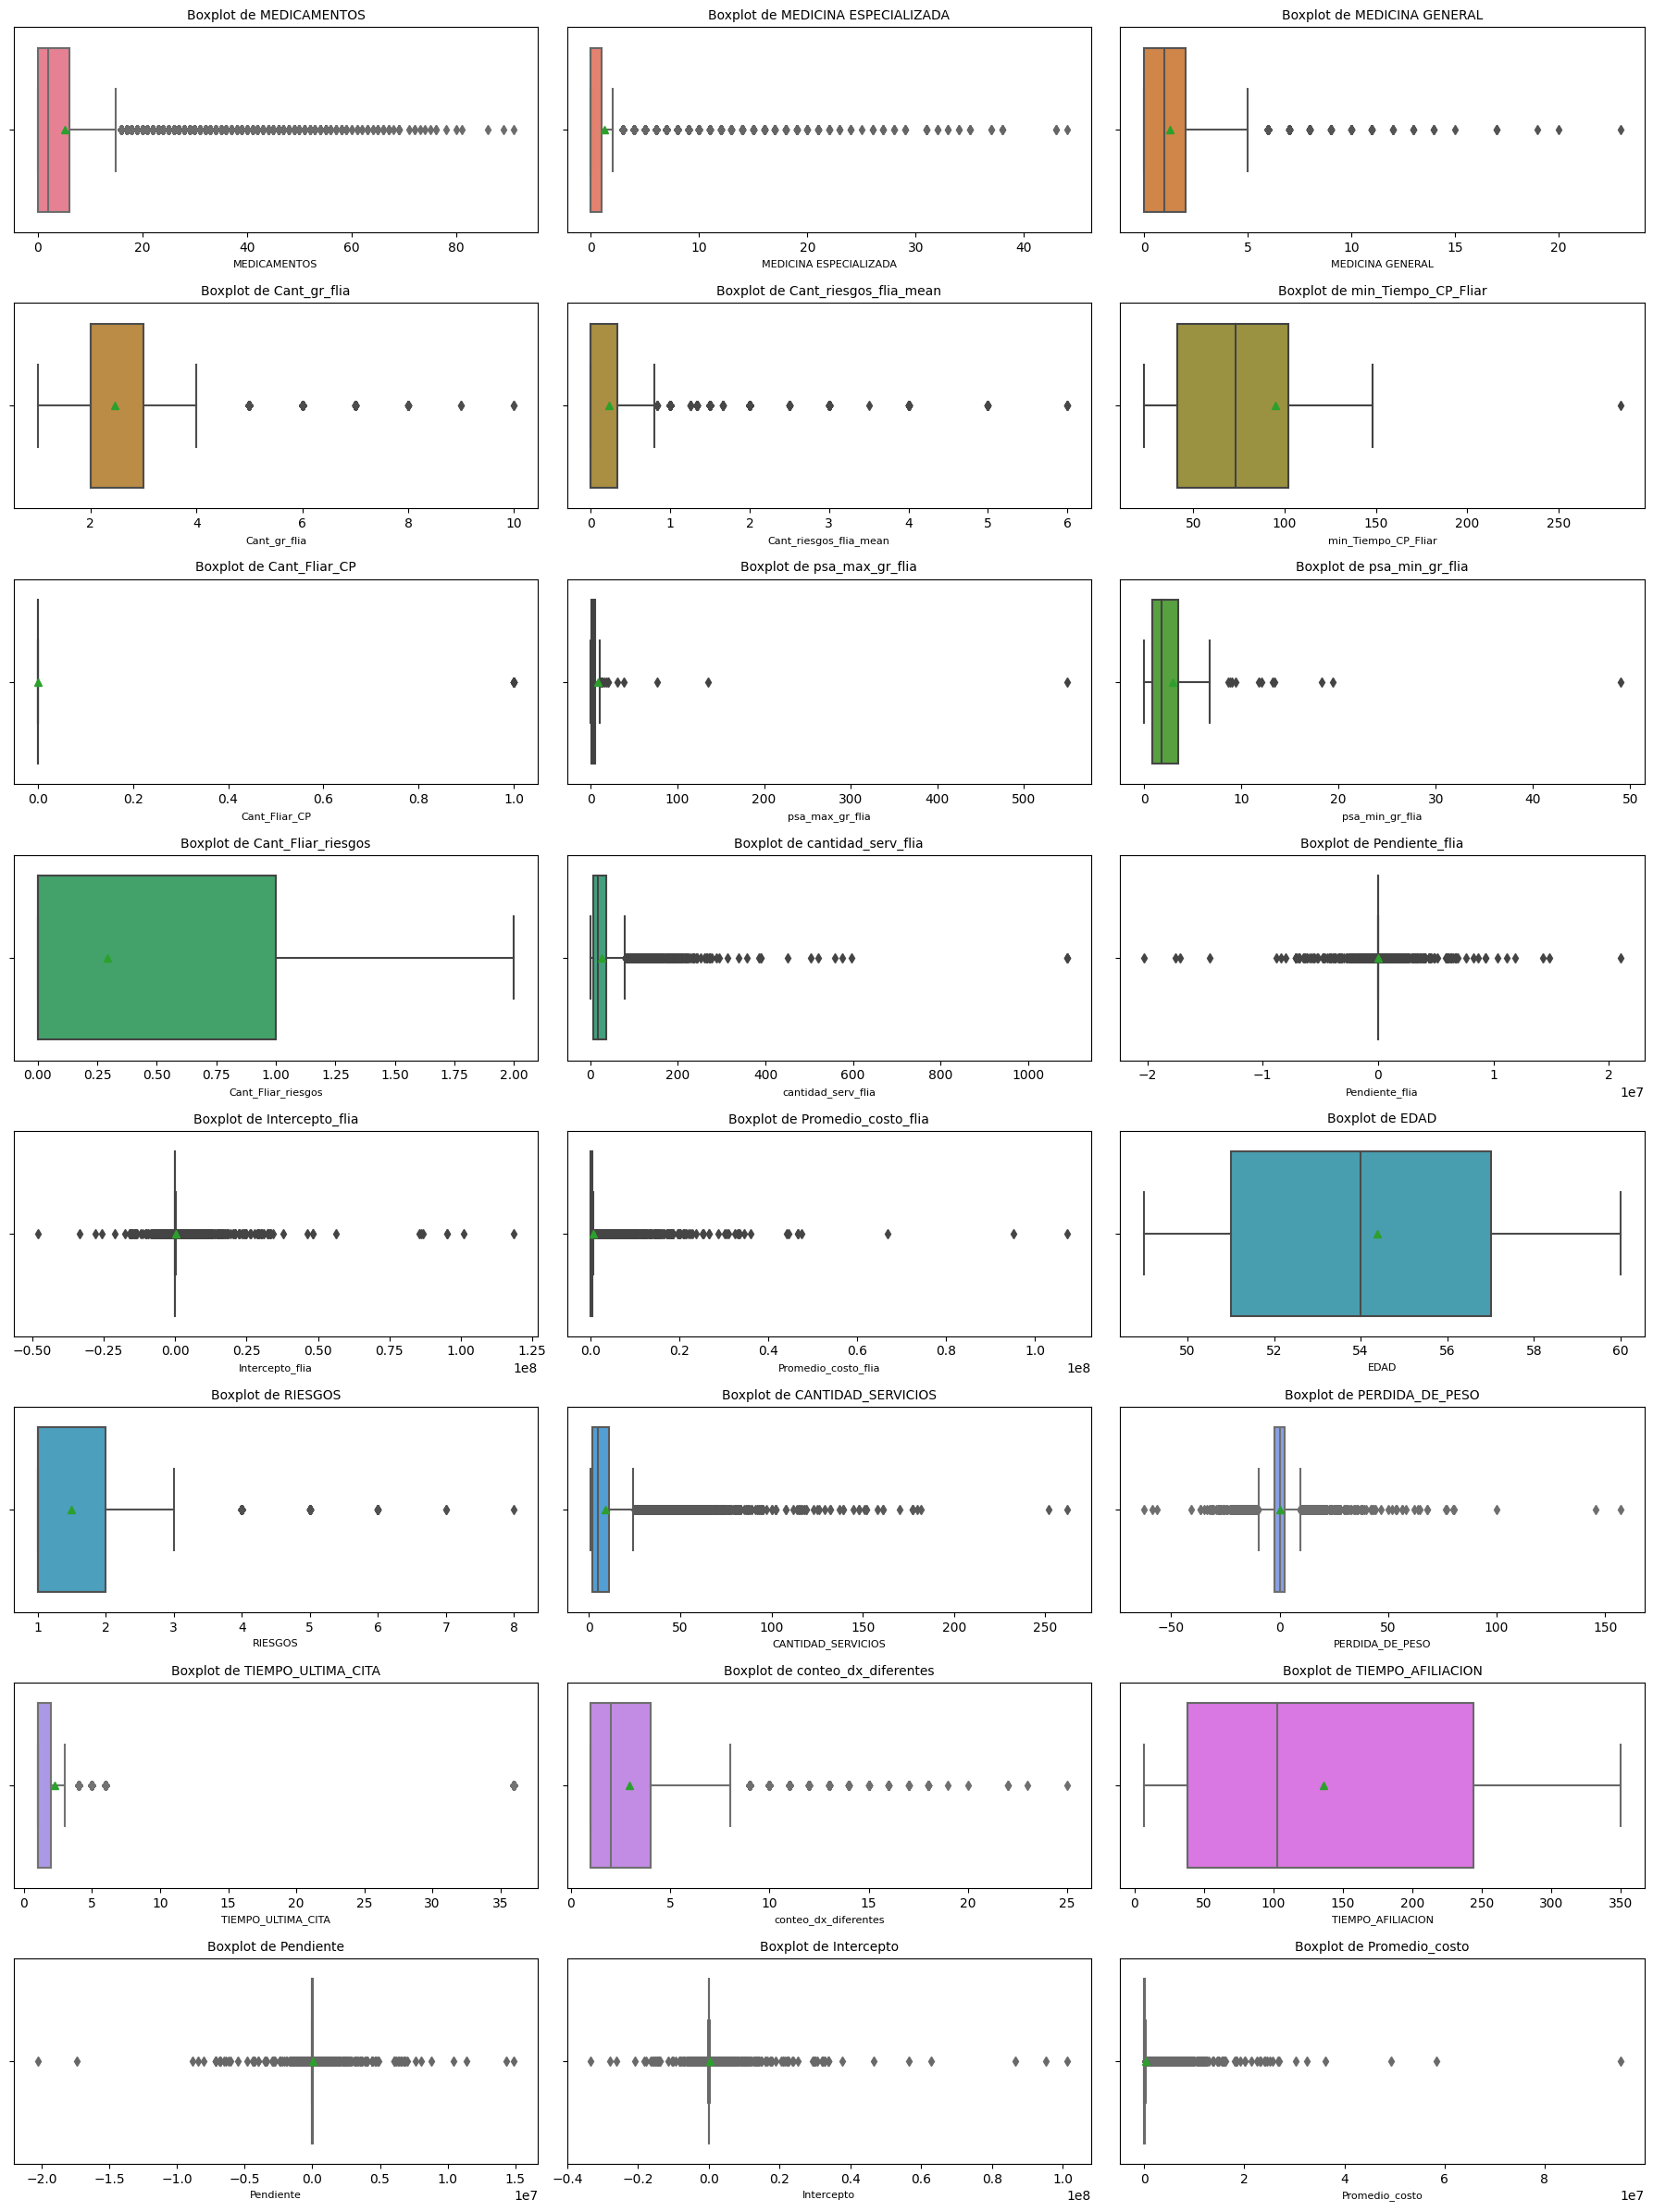

In [18]:
columnas_numericas = df_numerico.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(18, 24))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

colores = sns.color_palette("husl", len(columnas_numericas))

for i, (columna, ax) in enumerate(zip(columnas_numericas, axes.flatten())):
    sns.boxplot(x=df_numerico[columna].dropna(), color=colores[i], showmeans=True, ax=ax)
    ax.set_title(f'Boxplot de {columna}', fontsize=10)
    ax.set_xlabel(f'{columna}', fontsize=8)

for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


**Interpretación**

PENDIENTE

**Análisis de Correlación - Variables Numéricas**

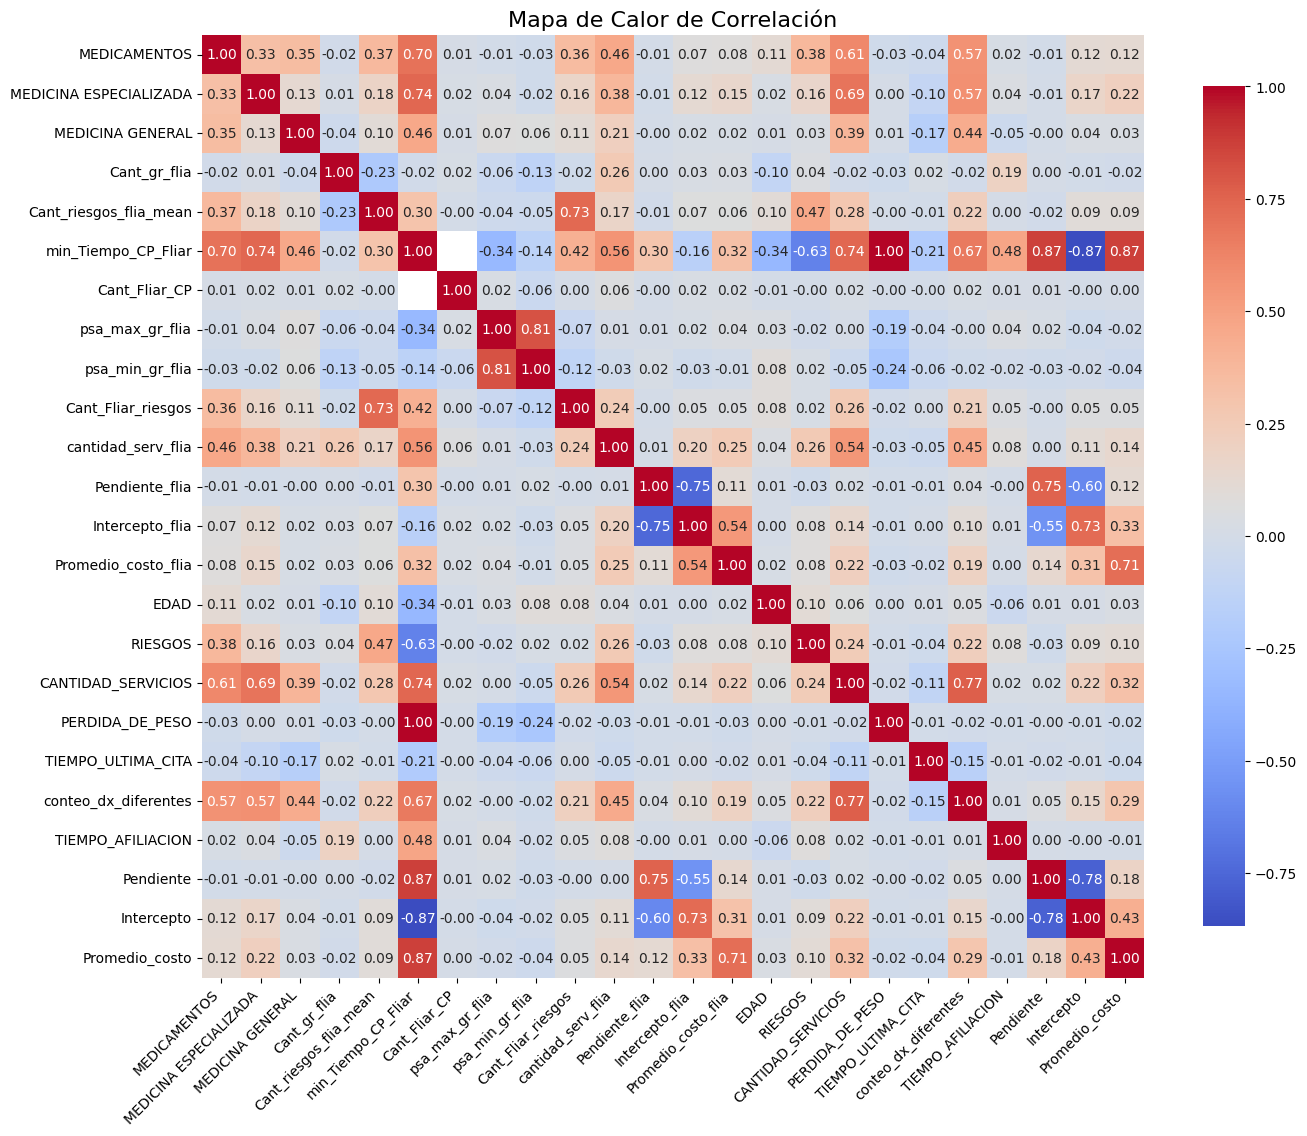

In [21]:
plt.figure(figsize=(14, 12))
sns.heatmap(df_numerico.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})


plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)  

plt.title('Mapa de Calor de Correlación', fontsize=16)
plt.tight_layout() 
plt.show()



**Interpretación**

PENDIENTE

**Análisis de Datos Nulos - Variables Numéricas**

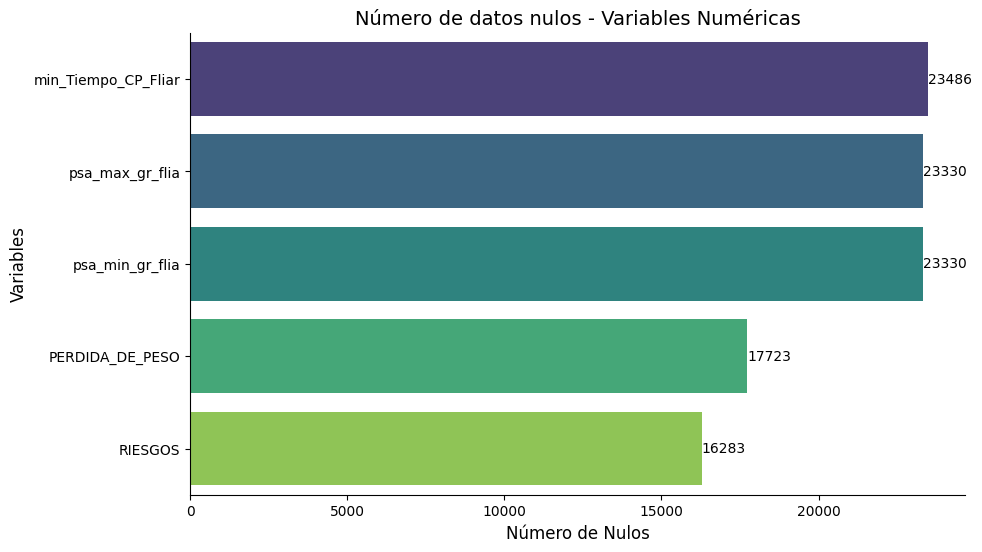

In [26]:
conteo_nulos = df_numerico.isnull().sum()

conteo_nulos = conteo_nulos[conteo_nulos > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=conteo_nulos.values, y=conteo_nulos.index, palette='viridis')

for index, value in enumerate(conteo_nulos.values):
    plt.text(value, index, str(value), color='black', va='center')

sns.despine()

plt.title('Número de datos nulos - Variables Numéricas', fontsize=14)
plt.xlabel('Número de Nulos', fontsize=12)
plt.ylabel('Variables', fontsize=12)

plt.show()


**Interpretación**

En la base de datos se identificaron un total de 24 variables numéricas. Según el gráfico anterior, 5 de ellas cuentan con la presencia de valores nulos en los datos, estas son: **min_Tiempo_CP_Fliar** (Tiempo desde la marca del CA de Prostata Familiar), **psa_max_gr_flia** (Resultado PSA Maximo del grupo familiar), **psa_min_gr_flia** (Resultado PSA Minimo del grupo familiar), **perdida_de_peso** (Peso perdido/ganado en el ultimo año) y **riesgos** (cantidad de riesgos del usuario).

Teniendo en cuenta el porcentaje de valores nulos para cada una de las variables en relación con el tamaño del dataset (23.494), este resultado parece sugerir la eliminación de alguna de estas variables: 

- **min_Tiempo_CP_Fliar** - 99% de datos nulos
- **psa_max_gr_flia** - 99,3%
- **psa_min_gr_flia** - 99,3%
- **perdida_de_peso** - 75,4%
- **riesgos** - 69,3%

No obstante, más adelante a lo largo de este análisis se harán propuestas de otras técnicas para entender la validez de estas variables sobre el modelo. Esto debido a que variables relacionadas con los resultados máximos o mínimos de PSA pueden generar algún tipo de importancia dentro de los análisis. 


**Otros Análisis**

Identificación del promedio de medicamentos usados por grupos de edad.

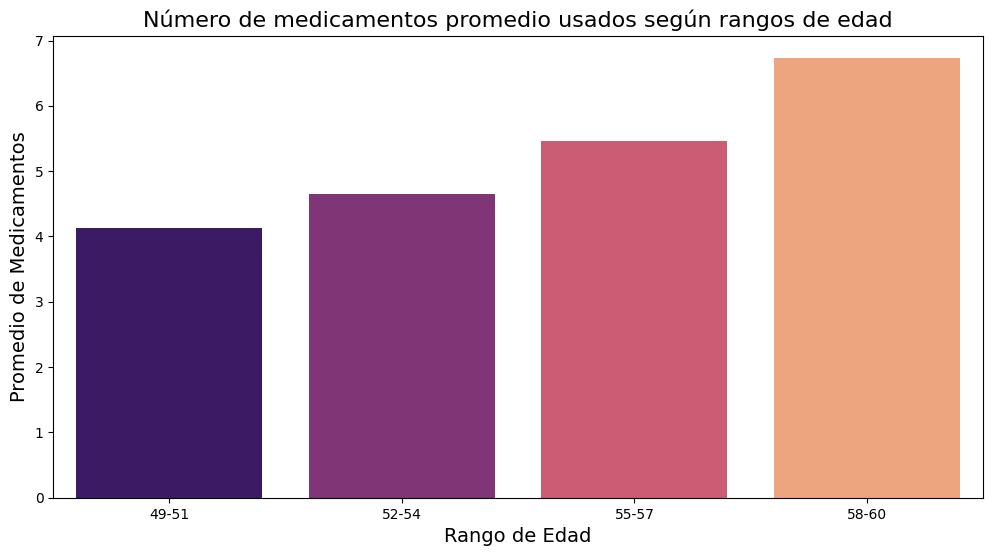

In [33]:
bins = [49, 52, 55, 58, 61] 
labels = ['49-51', '52-54', '55-57', '58-60']

df_numerico['Rango_Edad'] = pd.cut(df_numerico['EDAD'], bins=bins, labels=labels, right=False)

medicamentos_por_edad = df_numerico.groupby('Rango_Edad')['MEDICAMENTOS'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=medicamentos_por_edad, x='Rango_Edad', y='MEDICAMENTOS', palette='magma')  # Cambiar la paleta de colores

plt.title('Número de medicamentos promedio usados según rangos de edad', fontsize=16)
plt.xlabel('Rango de Edad', fontsize=14)
plt.ylabel('Promedio de Medicamentos', fontsize=14)

# Mostrar el gráfico
plt.show()


**Interpretación**

En el gráfico anterior, se propone un análisis en el cual se evidencia el promedio de medicamentos que utilizaron las personas según el rango de edad al que pertenecen. Para este conjunto de datos, se encontró que las personas que se encuentran en el grupo etario más avanzado son aquellos que utilizaron la mayor cantidad de medicamentos (en promedio), este valor correspondió a aproximadamente 6 medicamentos para las personas entre 58 a 60 años. Seguido a este grupo, aparecen las personas entre 55 y 57 años que usaron aproximadamente 5 medicamentos en promedio en el último semestre. 

Por supuesto, esto da un indicio que son las personas más longevas las que requieren una mayor cantidad de medicamentos debido a que es posible que cuenten con mayores problemas de salud. 

DSSFSDFDSF

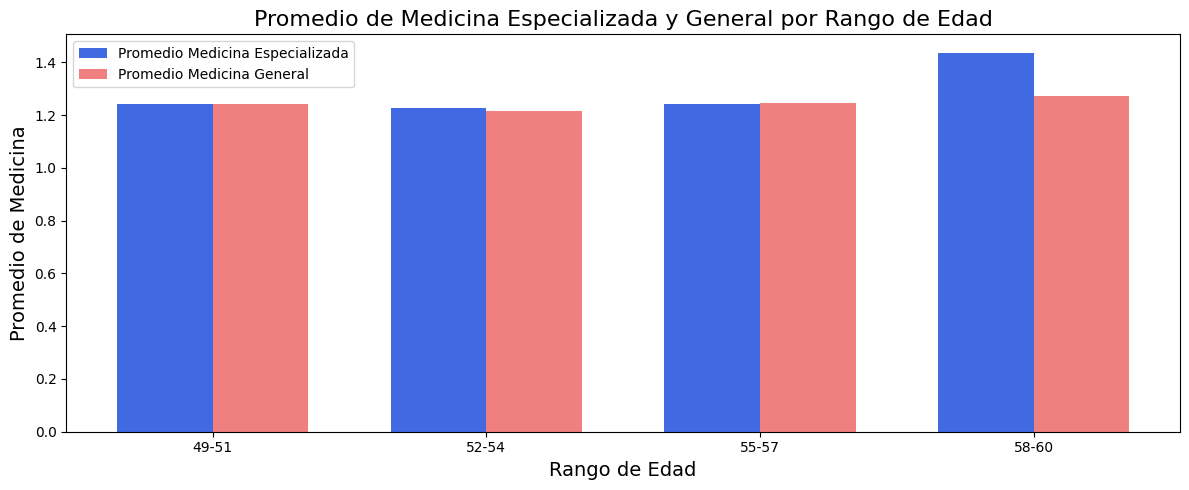

In [35]:
bins = [49, 52, 55, 58, 61]  # Rango de 49 a 60
labels = ['49-51', '52-54', '55-57', '58-60']


df_numerico['Rango_Edad'] = pd.cut(df_numerico['EDAD'], bins=bins, labels=labels, right=False)


medicina_especializada_por_edad = df_numerico.groupby('Rango_Edad')['MEDICINA ESPECIALIZADA'].mean().reset_index()
medicina_general_por_edad = df_numerico.groupby('Rango_Edad')['MEDICINA GENERAL'].mean().reset_index()


combined_data = pd.merge(medicina_especializada_por_edad, medicina_general_por_edad, on='Rango_Edad', suffixes=('_Especializada', '_General'))


plt.figure(figsize=(12, 5))
bar_width = 0.35  
x = range(len(combined_data['Rango_Edad']))


plt.bar(x, combined_data['MEDICINA ESPECIALIZADA'], width=bar_width, label='Promedio Medicina Especializada', color='royalblue')
plt.bar([p + bar_width for p in x], combined_data['MEDICINA GENERAL'], width=bar_width, label='Promedio Medicina General', color='lightcoral')


plt.title('Promedio de Medicina Especializada y General por Rango de Edad', fontsize=16)
plt.xlabel('Rango de Edad', fontsize=14)
plt.ylabel('Promedio de Medicina', fontsize=14)
plt.xticks([p + bar_width / 2 for p in x], combined_data['Rango_Edad'])  
plt.legend()


plt.tight_layout()
plt.show()


**Interpretación**

Previamente en las estadísticas descriptivas se observó que la cantidad de servicios de medicina (tanto especializada como general) era relativamente baja, lo cual se confirma en la gráfica anterior. Sin embargo, a pesar del bajo uso de servicios en los últimos semestres, el grupo etario de 58 a 60 años destaca por haber utilizado el mayor promedio de servicios de medicina especializada.

==============================================

## **2.2. Análisis Exploratorio de Variables Categóricas**

In [36]:
df_categorico.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   ESTADO_CIVI                    23494 non-null  object
 1   PROGRAMA                       23494 non-null  object
 2   estrato                        23494 non-null  object
 3   IMC                            13130 non-null  object
 4   AGRUPACION_SISTOLICA           20174 non-null  object
 5   AGRUPACION_DIASTOLICA          20174 non-null  object
 6   parentesco                     23494 non-null  object
 7   CANCER_MAMA_FAMILIAR           16692 non-null  object
 8   CANCER_OTRO_SITIO              23494 non-null  object
 9   CANCER_OTRO_SITIO_FAMILIAR     23494 non-null  object
 10  HIPERTENSION                   23494 non-null  object
 11  HIPERTENSION_FAMILIAR          23494 non-null  object
 12  DIABETES                       23494 non-null  object
 13  DIA

In [44]:
# Función para obtener tablas de frecuencias para las variables categóricas

def tabla_freq(columna):
    x=pd.crosstab(index=columna,columns="count").reset_index()
    x=x.rename(columns={'count':'Frec. Abs.'})
    y=pd.crosstab(index=columna,columns="count", normalize='columns').reset_index()
    y=y.rename(columns={'count':'Frec. Rel.'})
    tabla=x.merge(y,how='left')
    tabla.rename_axis(None, axis=1)
    return tabla

**Tablas de Frecuencia**

In [45]:
columnas_categoricas = df_categorico.select_dtypes(include=['object']).columns

resultados_categoricos = {}

for columna in columnas_categoricas:
    resultados_categoricos[columna] = tabla_freq(df_categorico[columna])

for key, value in resultados_categoricos.items():
    print(f"\nTabla de Frecuencia para {key}:\n")
    display(value)  # Mostrar la tabla con formato
    print("\n" + "="*50 + "\n")


Tabla de Frecuencia para ESTADO_CIVI:



col_0,ESTADO_CIVI,Frec. Abs.,Frec. Rel.
0,CA,10694,0.455180
1,None,125,0.005321
2,SE,371,0.015791
3,SO,5905,0.251341
4,UL,6377,0.271431
5,VI,22,0.000936





Tabla de Frecuencia para PROGRAMA:



col_0,PROGRAMA,Frec. Abs.,Frec. Rel.
0,PAC,125,0.005321
1,POS,21521,0.916021
2,RS,1848,0.078658





Tabla de Frecuencia para estrato:



col_0,estrato,Frec. Abs.,Frec. Rel.
0,0,214,0.009109
1,1,17675,0.752320
2,2,4063,0.172938
3,3,1540,0.065549
4,None,2,0.000085





Tabla de Frecuencia para IMC:



col_0,IMC,Frec. Abs.,Frec. Rel.
0,Bajo peso,68,0.005179
1,Normal,3722,0.283473
2,Obesidad,2791,0.212567
3,Sobrepeso,6549,0.498781





Tabla de Frecuencia para AGRUPACION_SISTOLICA:



col_0,AGRUPACION_SISTOLICA,Frec. Abs.,Frec. Rel.
0,Hipotenso,28,0.001388
1,Normal,18321,0.908149
2,hipertenso,1825,0.090463





Tabla de Frecuencia para AGRUPACION_DIASTOLICA:



col_0,AGRUPACION_DIASTOLICA,Frec. Abs.,Frec. Rel.
0,Hipotenso,1390,0.068901
1,Normal,17111,0.848171
2,hipertenso,1673,0.082929





Tabla de Frecuencia para parentesco:



col_0,parentesco,Frec. Abs.,Frec. Rel.
0,Conyuge,1058,0.045033
1,Hijo,12,0.000511
2,None,17125,0.728910
3,Otros,58,0.002469
4,Padres,197,0.008385
5,Sin Descripcion,170,0.007236
6,Trabajador,4874,0.207457





Tabla de Frecuencia para CANCER_MAMA_FAMILIAR:



col_0,CANCER_MAMA_FAMILIAR,Frec. Abs.,Frec. Rel.
0,0,16332,0.978433
1,1,360,0.021567





Tabla de Frecuencia para CANCER_OTRO_SITIO:



col_0,CANCER_OTRO_SITIO,Frec. Abs.,Frec. Rel.
0,0,13320,0.566953
1,1,3372,0.143526
2,2,6802,0.289521





Tabla de Frecuencia para CANCER_OTRO_SITIO_FAMILIAR:



col_0,CANCER_OTRO_SITIO_FAMILIAR,Frec. Abs.,Frec. Rel.
0,0,13638,0.580489
1,1,3054,0.129991
2,2,6802,0.289521





Tabla de Frecuencia para HIPERTENSION:



col_0,HIPERTENSION,Frec. Abs.,Frec. Rel.
0,0,11933,0.507917
1,1,4759,0.202562
2,2,6802,0.289521





Tabla de Frecuencia para HIPERTENSION_FAMILIAR:



col_0,HIPERTENSION_FAMILIAR,Frec. Abs.,Frec. Rel.
0,0,11576,0.492722
1,1,5116,0.217758
2,2,6802,0.289521





Tabla de Frecuencia para DIABETES:



col_0,DIABETES,Frec. Abs.,Frec. Rel.
0,0,13142,0.559377
1,1,3550,0.151102
2,2,6802,0.289521





Tabla de Frecuencia para DIABETES_FAMILIAR:



col_0,DIABETES_FAMILIAR,Frec. Abs.,Frec. Rel.
0,0,13421,0.571252
1,1,3271,0.139227
2,2,6802,0.289521





Tabla de Frecuencia para CORONARIOS:



col_0,CORONARIOS,Frec. Abs.,Frec. Rel.
0,0,14479,0.616285
1,1,2213,0.094194
2,2,6802,0.289521





Tabla de Frecuencia para CORONARIOS_FAMILIAR:



col_0,CORONARIOS_FAMILIAR,Frec. Abs.,Frec. Rel.
0,0,15208,0.647314
1,1,1484,0.063165
2,2,6802,0.289521





Tabla de Frecuencia para CEREBRAL:



col_0,CEREBRAL,Frec. Abs.,Frec. Rel.
0,0,15261,0.649570
1,1,1431,0.060909
2,2,6802,0.289521





Tabla de Frecuencia para CEREBRAL_FAMILIAR:



col_0,CEREBRAL_FAMILIAR,Frec. Abs.,Frec. Rel.
0,0,16288,0.693283
1,1,404,0.017196
2,2,6802,0.289521





Tabla de Frecuencia para ENFERMEDAD_RENAL:



col_0,ENFERMEDAD_RENAL,Frec. Abs.,Frec. Rel.
0,0,15356,0.653614
1,1,1336,0.056866
2,2,6802,0.289521





Tabla de Frecuencia para ENFERMEDAD_RENAL_FAMILIAR:



col_0,ENFERMEDAD_RENAL_FAMILIAR,Frec. Abs.,Frec. Rel.
0,0,16527,0.703456
1,1,165,0.007023
2,2,6802,0.289521





Tabla de Frecuencia para OTROS_ANTECEDENTES_VASCULARES:



col_0,OTROS_ANTECEDENTES_VASCULARES,Frec. Abs.,Frec. Rel.
0,0,16082,0.684515
1,1,610,0.025964
2,2,6802,0.289521


**Interpretación:**

PENDIENTE

**Distribución % de las categorías - Variables Categóricas**

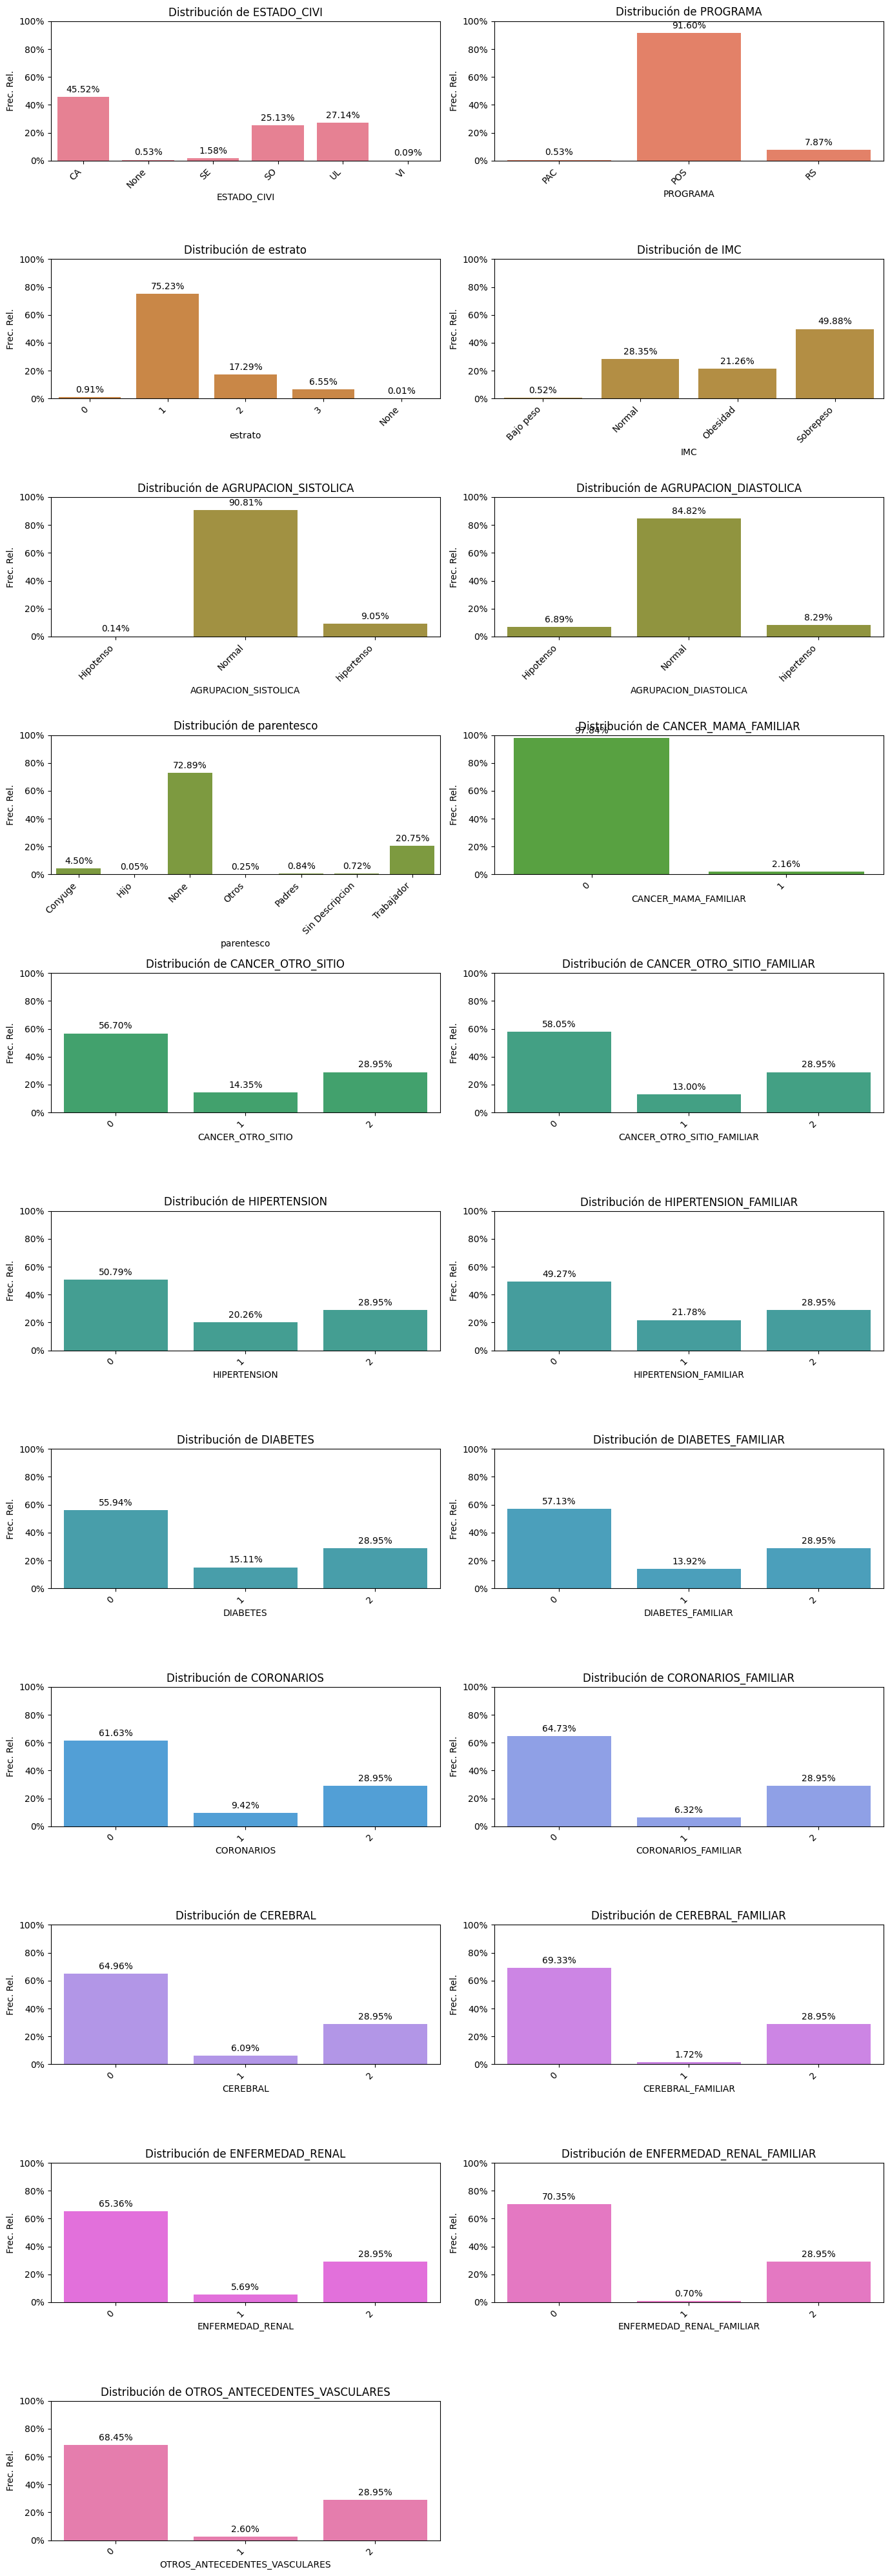

In [50]:
columnas_categoricas = df_categorico.select_dtypes(include=['object']).columns

# Presentación de los gráficos en términos de filas y columnas
n_filas = 11
n_columnas = 2
n_graficos = len(columnas_categoricas)

fig, axes = plt.subplots(n_filas, n_columnas, figsize=(14, 40))
axes = axes.flatten() 

colors = sns.color_palette("husl", n_graficos)

for i, columna in enumerate(columnas_categoricas):
    descriptivas = tabla_freq(df_categorico[columna])
    
    # Construcción del gráfico de barras
    frec_aprob = sns.barplot(
        ax=axes[i],
        x=descriptivas[columna],
        y=descriptivas["Frec. Rel."] * 100,
        color=colors[i]
    )
    
    # Añadir etiquetas de porcentaje
    frec_aprob.bar_label(frec_aprob.containers[0], label_type='edge', fmt='%.2f%%', padding=3)
    
    # Formato de porcentaje en el eje y
    frec_aprob.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
    frec_aprob.set(ylim=(0, 100))
    
    # Configurar el título
    axes[i].set_title(f'Distribución de {columna}', fontsize=12)
    
    axes[i].set_xticklabels(descriptivas[columna], rotation=45, ha='right')

# Ajustar el layout para evitar solapamientos
plt.tight_layout()

for j in range(n_graficos, n_filas * n_columnas):
    axes[j].axis('off')

plt.show()

**Interpretación** 

PENDIENTE

**En este punto, teniendo en cuenta la identificación de variables categóricas y numéricas, se llevará a cabo un Análisis Exploratorio Inicial, enfocado en un análisis descriptivo, para entender el comportamiento de las variables.** 

Interpretación: 

- Inicialmente, se encontró que los pacientes no están accediendo a la atención necesaria, pues hay un bajo uso de Medicina Especializada y General, teniendo en cuenta la media de la cantidad de servicios de ambos tipos de medicina en los últimos semestres (5,2 y 1,28 respectivamente).

- Teniendo en cuenta el promedio de la **cantidad de personas por grupo familiar**, se observa que la mayoría de las familias son relativamente pequeñas. 

- En relación con la **edad** de los pacientes se encontró una media de 54,37. Adicionalmente, se destaca que las edades oscilan en un rango de 49 a 60 años. 

- En el caso de la variable **riesgos**, se destaca que cuenta con una cantidad de 7.211 observaciones, es decir, que no se registró para todos los individuos que hay en el conjunto de datos. Para dicha variable la media es de 1,49, lo que sugiere que la mayoría de pacientes o usuarios parecen tener un bajo número de riesgos, un resultado positivo desde el punto de vista médico. 

- Ahora bien, realizando una primera aproximación de las variables que sugieren problemas de datos faltantes, se resaltan las siguientes: **min_Tiempo_CP_Fliar** (solo cuenta con 8 observaciones de 23.494), **psa_max_gr_flia** y **psa_min_gr_flia** (solo tienen 164 observaciones) y **RIESGOS** (tiene 7.211 observaciones)

**Análisis de Datos Nulos - Variables Categóricas**

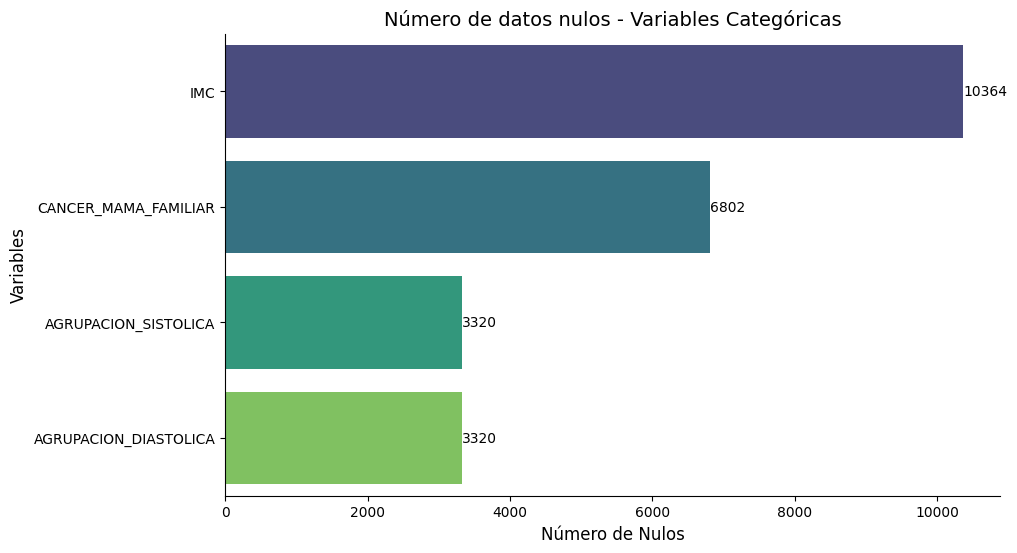

In [51]:
conteo_nulos_categorico = df_categorico.isnull().sum()
conteo_nulos_categorico = conteo_nulos_categorico[conteo_nulos_categorico > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=conteo_nulos_categorico.values, y=conteo_nulos_categorico.index, palette='viridis')

for index, value in enumerate(conteo_nulos_categorico.values):
    plt.text(value, index, str(value), color='black', va='center')

sns.despine()
plt.title('Número de datos nulos - Variables Categóricas', fontsize=14)
plt.xlabel('Número de Nulos', fontsize=12)
plt.ylabel('Variables', fontsize=12)

plt.show()

**Interpretación**

En la base de datos se identificaron un total de XX variables categóricas. A diferencia del análisis para variables numéricas, es importante resaltar que para este caso, las variables que presentan datos nulos no están tan graves en términos del % de los datos ausentes, en comparación con el estado de las variables con datos nulos de las numéricas. 

En este caso se identificaron 4 variables categóricas con presencia de nulos: 

- **IMC** - 44,1% de datos nulos 
- **CANCER_MAMA_FAMILIAR** - 28,9%
- **AGRUPACION_SISTOLICA** - 14,1%
- **AGRUPACION_DIASTOLICA** - 14,1%

En este caso, el panorama indica que es posible tratar estas variables con técnicas de imputación que se trabajarán más adelante. También, se resalta que se utilizarán técnicas para identificar si realmente estas variables son importantes para el modelo. 

**PENDIENTES Felipe M**

- Análisis o cruces entre categóricas y numéricas. 
- Análisis de feature selection

# **3. Entendimiento y Preparación de los Datos**

## **3.1. Análisis del Baseline**

## **3.2. Análisis de Missing Values**

## **3.3. Análisis de Outliers**

## **3.4. Imputación de Valores**

# **4. Feature Engineering**

## **4.1. Tratamiento de variables categóricas**

## **4.2. Uso de PCA**

## **4.3. Selección de variables**

# **5. Calibración y selección de modelo**

## **5.1. Custom Transformers**

## **5.2. Uso de Optimización bayesiana**

## **5.3. SVC con diferentes kernels**

## **5.4. Redes neuronales densas poco profundas**

## **5.5. Escogencia de Flujo Final**

====================================================

In [5]:
# get null values per column
df_train.isnull().sum()

MEDICAMENTOS                         0
MEDICINA ESPECIALIZADA               0
MEDICINA GENERAL                     0
Cant_gr_flia                         0
Cant_riesgos_flia_mean               0
min_Tiempo_CP_Fliar              23486
Cant_Fliar_CP                        0
psa_max_gr_flia                  23330
psa_min_gr_flia                  23330
Cant_Fliar_riesgos                   0
cantidad_serv_flia                   0
Pendiente_flia                       0
Intercepto_flia                      0
Promedio_costo_flia                  0
ESTADO_CIVI                          0
PROGRAMA                             0
estrato                              0
IMC                              10364
AGRUPACION_SISTOLICA              3320
AGRUPACION_DIASTOLICA             3320
parentesco                           0
EDAD                                 0
RIESGOS                          16283
CANTIDAD_SERVICIOS                   0
PERDIDA_DE_PESO                  17723
TIEMPO_ULTIMA_CITA       

In [6]:
# show the no null df_train['min_Tiempo_CP_Fliar']
df_train[df_train['min_Tiempo_CP_Fliar'].notnull()]['min_Tiempo_CP_Fliar']

ID
2040      80.0
31015    284.0
22231     23.0
17706     46.0
13338     87.0
1671      26.0
8816      66.0
7196     148.0
Name: min_Tiempo_CP_Fliar, dtype: float64

In [7]:
# Select only numeric columns
numeric_df = df_train.select_dtypes(include=['float64', 'int64'])


correlation_matrix = numeric_df.corr()

correlation_matrix



,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,EDAD,RIESGOS,CANTIDAD_SERVICIOS,PERDIDA_DE_PESO,TIEMPO_ULTIMA_CITA,conteo_dx_diferentes,TIEMPO_AFILIACION,Pendiente,Intercepto,Promedio_costo
MEDICAMENTOS,1.000000,0.331966,0.346059,-0.015767,0.371614,0.695983,0.009245,-0.013971,-0.027956,0.357199,...,0.113124,0.377758,0.612828,-0.027119,-0.042176,0.566136,0.018647,-0.011508,0.116113,0.121762
MEDICINA ESPECIALIZADA,0.331966,1.000000,0.129245,0.011969,0.178686,0.737621,0.017045,0.036545,-0.023520,0.163898,...,0.023354,0.160557,0.687308,0.002429,-0.097833,0.573364,0.037938,-0.006058,0.166837,0.217455
MEDICINA GENERAL,0.346059,0.129245,1.000000,-0.042558,0.096550,0.461383,0.010427,0.067307,0.062067,0.105518,...,0.008977,0.030664,0.388879,0.006403,-0.169069,0.442487,-0.045967,-0.000503,0.036462,0.029684
Cant_gr_flia,-0.015767,0.011969,-0.042558,1.000000,-0.225905,-0.020829,0.016781,-0.060778,-0.130187,-0.023462,...,-0.103675,0.044259,-0.015832,-0.030073,0.018722,-0.019230,0.191894,0.002699,-0.013514,-0.019755
Cant_riesgos_flia_mean,0.371614,0.178686,0.096550,-0.225905,1.000000,0.304156,-0.003517,-0.043661,-0.049443,0.731039,...,0.095760,0.465987,0.282375,-0.002263,-0.008023,0.222321,0.004889,-0.017130,0.090760,0.091223
min_Tiempo_CP_Fliar,0.695983,0.737621,0.461383,-0.020829,0.304156,1.000000,NaN,-0.339025,-0.140208,0.422714,...,-0.344192,-0.633000,0.737751,0.999203,-0.205217,0.666525,0.478542,0.874465,-0.868506,0.874545
Cant_Fliar_CP,0.009245,0.017045,0.010427,0.016781,-0.003517,NaN,1.000000,0.023342,-0.058842,0.003371,...,-0.006026,-0.004111,0.020248,-0.003366,-0.002173,0.016460,0.008433,0.010363,-0.004086,0.004863
psa_max_gr_flia,-0.013971,0.036545,0.067307,-0.060778,-0.043661,-0.339025,0.023342,1.000000,0.813872,-0.070896,...,0.034120,-0.017410,0.002910,-0.194678,-0.040942,-0.000894,0.042279,0.015499,-0.035937,-0.020689
psa_min_gr_flia,-0.027956,-0.023520,0.062067,-0.130187,-0.049443,-0.140208,-0.058842,0.813872,1.000000,-0.123574,...,0.083655,0.015039,-0.047103,-0.242213,-0.062555,-0.024445,-0.017917,-0.026866,-0.021488,-0.036650
Cant_Fliar_riesgos,0.357199,0.163898,0.105518,-0.023462,0.731039,0.422714,0.003371,-0.070896,-0.123574,1.000000,...,0.083898,0.021855,0.262561,-0.015209,0.001677,0.210846,0.046084,-0.003914,0.051992,0.051208


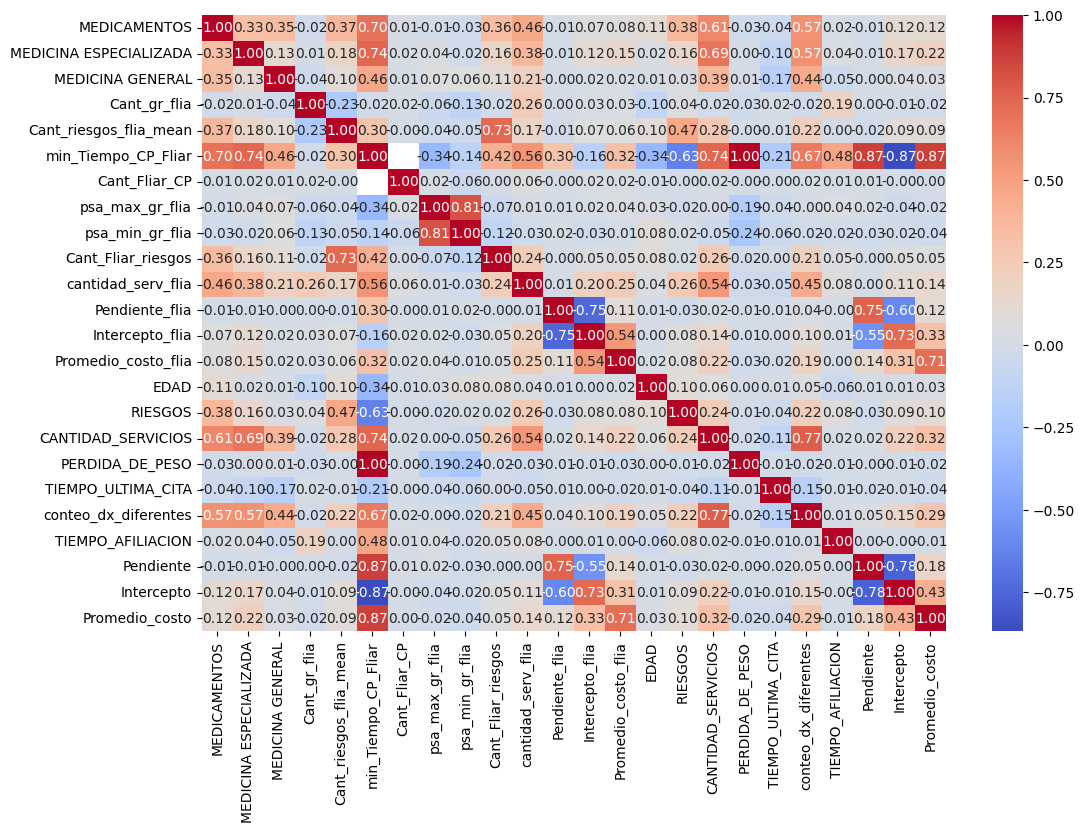

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Dimensionality Reduction

In [9]:
threshold = 0.8

corr_matrix = numeric_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

correlated_pairs = []

for column in upper.columns:
    high_corr = upper[column][upper[column] > threshold]
    if not high_corr.empty:
        correlated_pairs.append((column, high_corr.idxmax(), high_corr.max()))
print("Highly correlated pairs:")
for col, corr_col, corr_value in correlated_pairs:
    print(f"{col}-------------------------------- {corr_col}=========> (correlation = {corr_value:.2f})")
    print(f"Null values in {col}: {df_train[col].isnull().sum()}")
    print(f"Null values in {corr_col}: {df_train[corr_col].isnull().sum()}")
    print('=========')


Highly correlated pairs:
psa_min_gr_flia-------------------------------- psa_max_gr_flia=========> (correlation = 0.81)
Null values in psa_min_gr_flia: 23330
Null values in psa_max_gr_flia: 23330
PERDIDA_DE_PESO-------------------------------- min_Tiempo_CP_Fliar=========> (correlation = 1.00)
Null values in PERDIDA_DE_PESO: 17723
Null values in min_Tiempo_CP_Fliar: 23486
Pendiente-------------------------------- min_Tiempo_CP_Fliar=========> (correlation = 0.87)
Null values in Pendiente: 0
Null values in min_Tiempo_CP_Fliar: 23486
Intercepto-------------------------------- min_Tiempo_CP_Fliar=========> (correlation = 0.87)
Null values in Intercepto: 0
Null values in min_Tiempo_CP_Fliar: 23486
Promedio_costo-------------------------------- min_Tiempo_CP_Fliar=========> (correlation = 0.87)
Null values in Promedio_costo: 0
Null values in min_Tiempo_CP_Fliar: 23486


Based on the high correlations and the number of null values, I would make the following decisions:

### 1. **psa_min_gr_flia vs. psa_max_gr_flia**:
   - **Correlation**: 0.81, which is quite high.
   - **Null values**: Both columns have the same number of missing values (23,330).
   
   **Decision**: Drop `psa_min_gr_flia` and keep `psa_max_gr_flia`.
   - Reason: These columns are highly correlated, and keeping both adds redundancy. Since both have the same number of nulls, it's safe to drop one, and `psa_max_gr_flia` may represent a more useful or meaningful metric (max PSA levels typically indicate higher risk in clinical contexts).

### 2. **PERDIDA_DE_PESO vs. min_Tiempo_CP_Fliar**:
   - **Correlation**: 1.00, which indicates perfect correlation.
   - **Null values**: `PERDIDA_DE_PESO` has 17,723 nulls, while `min_Tiempo_CP_Fliar` has 23,486 nulls.
   
   **Decision**: Drop `PERDIDA_DE_PESO` and keep `min_Tiempo_CP_Fliar`.
   - Reason: Since the correlation is perfect (1.00), both variables convey the same information. Given that `min_Tiempo_CP_Fliar` has more null values, it might indicate a more precise variable, representing time intervals for family prostate cancer diagnosis, which could be a stronger predictor in prostate cancer cases than weight loss.

### 3. **Pendiente vs. min_Tiempo_CP_Fliar**:
   - **Correlation**: 0.87, a very strong positive correlation.
   - **Null values**: `Pendiente` has no nulls, while `min_Tiempo_CP_Fliar` has 23,486 nulls.
   
   **Decision**: Drop `min_Tiempo_CP_Fliar` and keep `Pendiente`.
   - Reason: Since `Pendiente` has no null values and provides the same information as `min_Tiempo_CP_Fliar` (with a correlation of 0.87), it is a more complete variable. `min_Tiempo_CP_Fliar` has significant null values, which makes it less reliable.

### 4. **Intercepto vs. min_Tiempo_CP_Fliar**:
   - **Correlation**: 0.87, also very strong.
   - **Null values**: `Intercepto` has no nulls, while `min_Tiempo_CP_Fliar` has 23,486 nulls.
   
   **Decision**: Drop `min_Tiempo_CP_Fliar` and keep `Intercepto`.
   - Reason: Same as above. Since `Intercepto` has no nulls and has a high correlation with `min_Tiempo_CP_Fliar`, it’s better to keep `Intercepto`.

### 5. **Promedio_costo vs. min_Tiempo_CP_Fliar**:
   - **Correlation**: 0.87, similar to `Pendiente` and `Intercepto`.
   - **Null values**: `Promedio_costo` has no nulls, while `min_Tiempo_CP_Fliar` has 23,486 nulls.
   
   **Decision**: Drop `min_Tiempo_CP_Fliar` and keep `Promedio_costo`.
   - Reason: Again, due to the high correlation and the fact that `Promedio_costo` has no nulls, it’s more reliable to keep `Promedio_costo` and drop `min_Tiempo_CP_Fliar`.

### Final Decisions:
- **Drop**:
   - `psa_min_gr_flia`
   - `PERDIDA_DE_PESO`
   - `min_Tiempo_CP_Fliar` (since it's correlated with multiple columns and has many nulls)

- **Keep**:
   - `psa_max_gr_flia`
   - `Pendiente`
   - `Intercepto`
   - `Promedio_costo`

By dropping the columns with high correlations and keeping the most complete and relevant columns, you reduce redundancy and improve the dataset’s quality for further analysis or modeling. Let me know if you need further adjustments!

In [10]:
to_drop = ['psa_min_gr_flia','PERDIDA_DE_PESO', 'min_Tiempo_CP_Fliar']
df_train.drop(to_drop, axis=1, inplace=True)


In [10]:
len(df_train.columns)

46

In [11]:
df_train.isnull().sum()[df_train.isnull().sum() > 0]

min_Tiempo_CP_Fliar      23486
psa_max_gr_flia          23330
psa_min_gr_flia          23330
IMC                      10364
AGRUPACION_SISTOLICA      3320
AGRUPACION_DIASTOLICA     3320
RIESGOS                  16283
PERDIDA_DE_PESO          17723
CANCER_MAMA_FAMILIAR      6802
dtype: int64

In [12]:
df_train[df_train.isnull().sum()[df_train.isnull().sum() > 0].index]

,min_Tiempo_CP_Fliar,psa_max_gr_flia,psa_min_gr_flia,IMC,AGRUPACION_SISTOLICA,AGRUPACION_DIASTOLICA,RIESGOS,PERDIDA_DE_PESO,CANCER_MAMA_FAMILIAR
ID,,,,,,,,,
16484,NaN,NaN,NaN,Sobrepeso,Normal,Normal,NaN,NaN,0
11528,NaN,NaN,NaN,Sobrepeso,Normal,Normal,NaN,NaN,0
26630,NaN,NaN,NaN,Sobrepeso,Normal,Normal,NaN,NaN,0
12586,NaN,NaN,NaN,Sobrepeso,Normal,Normal,NaN,NaN,0
11225,NaN,NaN,NaN,Obesidad,Normal,Normal,1.0,NaN,None
...,...,...,...,...,...,...,...,...,...
7141,NaN,NaN,NaN,Bajo peso,Normal,Normal,NaN,NaN,0
15417,NaN,NaN,NaN,Sobrepeso,Normal,Normal,1.0,-6.25,None
19389,NaN,NaN,NaN,Sobrepeso,Normal,Hipotenso,NaN,1.35,None


## Pipeline to input columns
- Vamos a imputar features numericas y categoricas de manera separada en un pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

X = df_train.drop(columns=['Target'])
y = df_train['Target']

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

X_imputed = preprocessor.fit_transform(X)
categorical_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)

all_feature_names = np.concatenate([numeric_cols, categorical_feature_names])

X_imputed_df = pd.DataFrame(X_imputed, columns=all_feature_names)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_imputed_df, y, test_size=0.2, random_state=42)

import xgboost as xgb
from sklearn.metrics import r2_score

xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgboost_model.fit(X_train_final, y_train_final)

y_pred_final = xgboost_model.predict(X_test_final)

r2_final = r2_score(y_test_final, y_pred_final)
print(f"R² score on test data using imputed dataset: {r2_final:.4f}")


## Baseline using XG-Boost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_imputed_df, y, test_size=0.2, random_state=42)
xgboost_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgboost_classifier.fit(X_train_final, y_train_final)
y_pred_final = xgboost_classifier.predict(X_test_final)
accuracy = accuracy_score(y_test_final, y_pred_final)
precision = precision_score(y_test_final, y_pred_final)
recall = recall_score(y_test_final, y_pred_final)
f1 = f1_score(y_test_final, y_pred_final)

# Print classification metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
